In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
from matplotlib.colors import LogNorm

mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble =r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

%matplotlib inline

In [2]:
PATH= '/results2/SalishSea/nowcast-green.201905/'
modver='HC1905'
start_date = dt.datetime(2013,1,1)
end_date = dt.datetime(2017,1,1)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}
rematch=False
if rematch==True:
    df1=et.loadDFOCTD()
    df1.head()

In [5]:
saveloc='./'
fname=f'data_DFOCTD_{modver}_{start_date.strftime("%Y%m%d")}_{end_date.strftime("%Y%m%d")}'
if rematch==True:
    data=et.matchData(df1,filemap, fdict, start_date, end_date, namfmt, PATH, flen)
    pickle.dump(data,open(os.path.join(saveloc,fname)+'.pkl','wb'))
else:
    data=pickle.load(open(os.path.join(saveloc,fname)+'.pkl','rb'))

In [4]:
#data=pickle.load(open(os.path.join(saveloc,fname)+'.pkl','rb'))

In [6]:
print(data.head())

     Year  Month   Day       Hour        Lat      Lon         Z         SA  \
0  2014.0    1.0  15.0  17.465556  49.329667 -124.081  0.991487  28.448958   
1  2014.0    1.0  15.0  17.465556  49.329667 -124.081  1.982969  28.449707   
2  2014.0    1.0  15.0  17.465556  49.329667 -124.081  2.974446  28.451662   
3  2014.0    1.0  15.0  17.465556  49.329667 -124.081  3.965919  28.483562   
4  2014.0    1.0  15.0  17.465556  49.329667 -124.081  4.957386  28.738536   

         CT  Fluor               dtUTC    j    i  mod_vosaline  mod_votemper  \
0  7.535776    NaN 2014-01-15 17:27:56  526  206     26.507793      6.950379   
1  7.536083    NaN 2014-01-15 17:27:56  526  206     26.509628      6.957670   
2  7.534659    NaN 2014-01-15 17:27:56  526  206     26.525661      6.976134   
3  7.535744    NaN 2014-01-15 17:27:56  526  206     26.583195      7.010254   
4  7.582821    NaN 2014-01-15 17:27:56  526  206     26.700645      7.064485   

   k  
0  0  
1  1  
2  2  
3  3  
4  4  


In [7]:
def rotmap(lon,lat,lon0,lat0,phi):
    # rotate around point (pick one near center of domain)
    # phi in degrees
    # first scale lats to match and center around lat0,lon0:
    lon1=(lon-lon0)*np.cos(lat0*np.pi/180)
    lat1=lat-lat0
    # now rotate:
    lon2=lon1*np.cos(phi*np.pi/180)-lat1*np.sin(phi*np.pi/180)
    lat2=lon1*np.sin(phi*np.pi/180)+lat1*np.cos(phi*np.pi/180)
    return lon2,lat2

In [8]:
cm1=cmocean.cm.thermal
#plt.get_cmap('PuBuGn')
#cm1=cmo.cm.matter
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])
blon,blat=rotmap(bathylon,bathylat,lon0,lat0,theta)

In [9]:
cver = "BIO"
clusterD='/data/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/'
cfile = {2013:"BIO_clno_5_2013_reass.pkl",2014:"BIO_clno_5_2014_reass.pkl", 
         2015: "BIO_clno_5_2015_reass.pkl", 2016: "BIO_clno_5_2016_reass.pkl"}
cxf='Xcoords_for571_stations.pkl'
cyf='Ycoords_for571_stations.pkl'
print('Cluster version is:', cver)
# papermill reads dictionary keys as strings, so add code to correct this
cfile2=dict()
for key,val in cfile.items():
    cfile2[int(key)]=val
cfile=cfile2
cx=pickle.load(open(clusterD+cxf, 'rb'))
cy=pickle.load(open(clusterD+cyf, 'rb'))
cf=dict()
for iyear in cfile.keys():
    cf[iyear]=pickle.load(open(clusterD+cfile[iyear],'rb'))

def round2(num):
    return int(np.trunc((num+2)/10)*10+2)

data['Cluster']=np.zeros(len(data))
for ir, row in data.iterrows():
    if (ir%5000 == 0):
        print(ir)
    ii=(cx==round2(row['i']))&(cy==round2(row['j']))
    if sum(ii)==1:
        cluster=cf[row['Year']][ii]
        data.at[ir,'Cluster']=int(cluster)

Cluster version is: BIO
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000
360000
365000
370000
375000
380000
385000
390000
395000
400000
405000
410000
415000


In [ ]:
# tdir = '/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/'
# w = pd.read_csv(tdir+'data_DFOCTD_HC1905_20130101_20170101.csv')
# print(w.head())

# np.nanmin(w['Year'])

In [10]:
fname2=f'data_DFOCTD_byCLUST_{modver}_{start_date.strftime("%Y%m%d")}_{end_date.strftime("%Y%m%d")}'
pickle.dump(data,open(os.path.join(saveloc,fname2)+'.pkl','wb'))

In [11]:
data=pickle.load(open(os.path.join(saveloc,fname2)+'.pkl','rb'))

In [12]:
print(data.head())

     Year  Month   Day       Hour        Lat      Lon         Z         SA  \
0  2014.0    1.0  15.0  17.465556  49.329667 -124.081  0.991487  28.448958   
1  2014.0    1.0  15.0  17.465556  49.329667 -124.081  1.982969  28.449707   
2  2014.0    1.0  15.0  17.465556  49.329667 -124.081  2.974446  28.451662   
3  2014.0    1.0  15.0  17.465556  49.329667 -124.081  3.965919  28.483562   
4  2014.0    1.0  15.0  17.465556  49.329667 -124.081  4.957386  28.738536   

         CT  Fluor               dtUTC    j    i  mod_vosaline  mod_votemper  \
0  7.535776    NaN 2014-01-15 17:27:56  526  206     26.507793      6.950379   
1  7.536083    NaN 2014-01-15 17:27:56  526  206     26.509628      6.957670   
2  7.534659    NaN 2014-01-15 17:27:56  526  206     26.525661      6.976134   
3  7.535744    NaN 2014-01-15 17:27:56  526  206     26.583195      7.010254   
4  7.582821    NaN 2014-01-15 17:27:56  526  206     26.700645      7.064485   

   k  Cluster  
0  0      3.0  
1  1      3.0  
2 

In [26]:
y_ar = np.arange(0,31,1)
print(y_ar)
bins=[y_ar,y_ar]



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


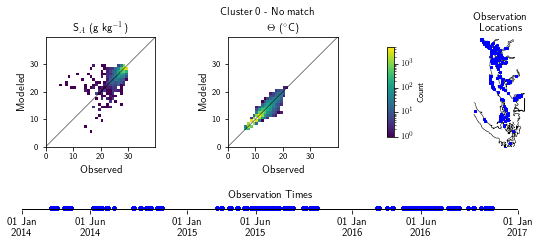

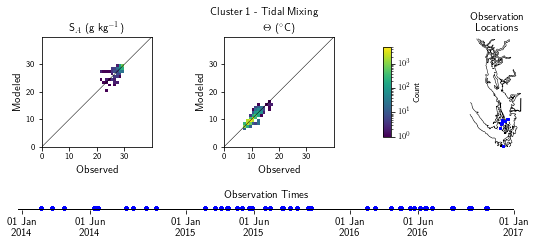

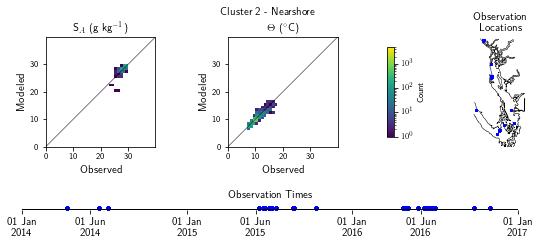

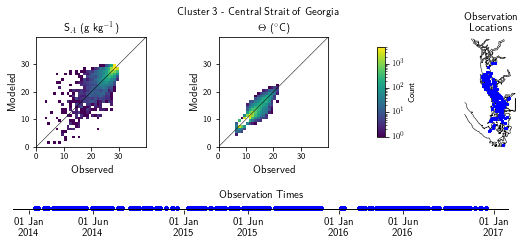

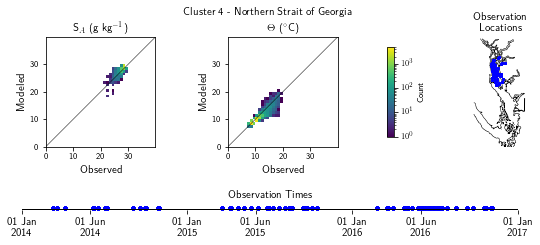

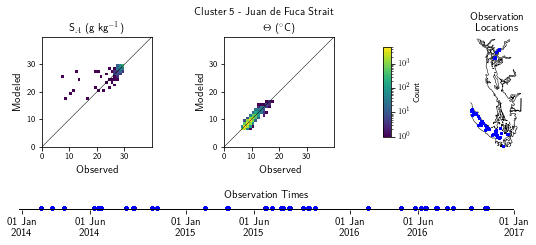

In [31]:
clnams = ['No match', 'Tidal Mixing', 'Nearshore',\
          'Central Strait of Georgia', 'Northern Strait of Georgia', 'Juan de Fuca Strait']
fs = 11
for ic in np.unique(data['Cluster']):
    clnam = clnams[int(ic)]
    bounds = np.array([0,5,10,15,20,40,100,200,450])
    norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    #pcm = ax[1].pcolormesh(X, Y, Z1, norm=norm, cmap='RdBu_r')
    tm=40
    sm=40

    fig = plt.figure(figsize = (8.1,3.2))
    gsv = gridspec.GridSpec(2,1,left=.08,right=.98,hspace=1,bottom=.1,top=.85,height_ratios=[4,.2])
    gs1=gridspec.GridSpecFromSubplotSpec(1,5,subplot_spec=gsv[0],wspace=.3,hspace=.34,
                                         width_ratios=[1,1,.05,.05,.6])
    axSA = fig.add_subplot(gs1[0])
    axCT = fig.add_subplot(gs1[1])
    axLmap = fig.add_subplot(gs1[-1])

    gscb = gridspec.GridSpecFromSubplotSpec(11,1,subplot_spec=gs1[2])
    axcb = fig.add_subplot(gscb[1:-1])

    axL=fig.add_subplot(gsv[1])

    axSA.plot((0,sm),(0,sm),'k-',lw=.5)
    axCT.plot((0,tm),(0,tm),'k-',lw=.5)

    vm0=-150
    args={'marker':'.','s':2,'norm':norm}
    dataCl=data.loc[(data.Cluster==ic)]
    #ps=et.varvarScatter(axSA,dataCl,'SA','mod_vosaline','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
    #ps=et.varvarScatter(axCT,dataCl,'CT','mod_votemper','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
    
    iiT=(~np.isnan(dataCl['CT']))&(~np.isnan(dataCl['mod_votemper']))
    iiS=(~np.isnan(dataCl['SA']))&(~np.isnan(dataCl['mod_vosaline']))
    counts, xedges, yedges, m1=axCT.hist2d(dataCl.loc[iiT,['CT']].values.flatten(),
                                          dataCl.loc[iiT,['mod_votemper']].values.flatten(),bins=[y_ar,y_ar],norm=LogNorm(vmin=1,vmax=5*10**3),
                                           cmin=1,cmax=5*10**3)
    counts, xedges, yedges, m2=axSA.hist2d(dataCl.loc[iiS,['SA']].values.flatten(),
                                          dataCl.loc[iiS,['mod_vosaline']].values.flatten(),bins=[y_ar,y_ar],norm=LogNorm(vmin=1,vmax=5*10**3),
                                           cmin=1,cmax=5*10**3)
    cb=fig.colorbar(m1,cax=axcb)
    cb.set_label('Count')
    #cb.set_ylim(0,450)

    ntick=np.arange(0,sm,int(sm/4))
    ntickl=[str(i) for i in ntick]
    for ax in (axSA,):
        ax.set_xlim((0,sm))
        ax.set_ylim((0,sm))
        ax.set_xticks(ntick)
        ax.set_xticklabels(ntickl)
        ax.set_yticks(ntick)
        ax.set_yticklabels(ntickl)

    stick=np.arange(0,tm,int(tm/4))
    stickl=[str(i) for i in stick]
    for ax in (axCT,):
        ax.set_xlim((0,tm))
        ax.set_ylim((0,tm))
        ax.set_xticks(stick)
        ax.set_xticklabels(stickl)
        ax.set_yticks(stick)
        ax.set_yticklabels(stickl)


    for ax in (axSA,axCT,):
        ax.set_aspect(1, adjustable='box')
        #ax.set_xlabel('Observed')

    axSA.set_ylabel('Modeled',fontsize=11)
    axCT.set_ylabel('Modeled',fontsize=11)
    axSA.set_xlabel('Observed',fontsize=11)
    axCT.set_xlabel('Observed',fontsize=11)


    axSA.set_title('S$_A$ (g kg$^{-1}$)',fontsize=11)
    axCT.set_title('$\Theta$ ($^{\circ}$C)',fontsize=11)

    #viz_tools.set_aspect(axLmap)
    for axLi in (axLmap,):
        axLi.set_aspect(1, adjustable='box')
        contour_lines = axLi.contour(blon,blat,bathyZ,[1e-5],
                    colors='black',zorder=2,linewidths=.5)
        axLi.set_xlim(-1.02,0.81)
        axLi.set_ylim(-1.5,1.8)
        axLi.axis('off')
    dataTSCl=dataCl.loc[(dataCl.SA>=0)|(dataCl.CT>=0)]

    lons15,lats15=rotmap(dataTSCl['Lon'], dataTSCl['Lat'],lon0,lat0,theta)
    axLmap.plot(lons15,lats15, '.',color='blue',markersize=2)
    axLmap.set_title('Observation\nLocations',fontsize=11)

    axL.set_title('Observation Times',fontsize=11)
    p1a,=axL.plot(dataTSCl.dtUTC,np.zeros(np.shape(dataTSCl.dtUTC)),'.',color='blue',markersize=6)
    axL.set_yticks(());
    
    
    axL.xaxis.set_ticks([
                         dt.datetime(2014,1,1), dt.datetime(2014,6,1),
                         dt.datetime(2015,1,1), dt.datetime(2015,6,1),
                         dt.datetime(2016,1,1), dt.datetime(2016,6,1),
                         dt.datetime(2017,1,1)])
     
    #labels=axL.xaxis.get_ticklabels()
    labels = ['01 Jan \n2014','01 Jun \n2014',\
              '01 Jan \n2015','01 Jun \n2015','01 Jan \n2016','01 Jun \n2016',
              '01 Jan \n2017']
    
    axL.xaxis.set_ticklabels(labels, fontsize = fs)
#    yearsFmt = mdates.DateFormatter('%d %b %Y')
#    axL.xaxis.set_major_formatter(yearsFmt)

#     axL.xaxis.set_ticks([dt.datetime(2013,1,1),
#                          dt.datetime(2014,1,1),
#                          dt.datetime(2015,1,1),
#                          dt.datetime(2016,1,1), 
#                          dt.datetime(2017,1,1)])
#     #labels=axL.xaxis.get_ticklabels()
#     for tick in axL.get_xticklabels():
#             #tick.set_rotation(90)
#             tick.set_horizontalalignment('center')
    axL.set_ylim(-.1,.3)
    axLpos=axL.get_position()
    new = mpl.transforms.Bbox.from_bounds(axLpos.bounds[0],axLpos.bounds[1],axLpos.bounds[2]-.05,axLpos.bounds[3])
    axL.set_position(new)
    #axL.legend(handles=[p1,p2,p3],loc=8,ncol=3,bbox_to_anchor=[.5,-4])
    axL.set_frame_on(False)
    #axL.axes.get_yaxis().set_visible(False)
    #axL.axes.get_xaxis().set_visible(True)
    xmin, xmax = axL.get_xaxis().get_view_interval()
    ymin, ymax = axL.get_yaxis().get_view_interval()
    axL.add_artist(mpl.lines.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
#     fig.suptitle('Cluster '+str(ic))
    fig.suptitle(f'Cluster {str(int(ic))} - {clnam}', fontsize = 11)
    #fig.savefig(f'/data/eolson/results/MEOPAR/figs/eval/dfoCTDEval{modver}_Cluster{int(ic)}.png',dpi=200,transparent=True)

Text(0.5, 0.98, 'All Data')

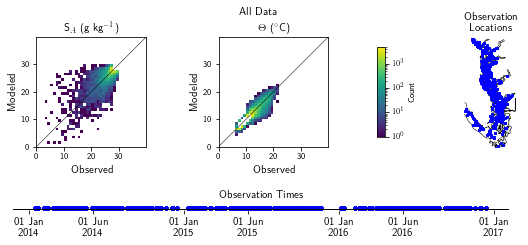

In [32]:
clnams = ['No match', 'Tidal Mixing', 'Nearshore',\
      'Central Strait of Georgia', 'Northern Strait of Georgia', 'Juan de Fuca Strait']
fs = 11
#for ic in np.unique(data['Cluster']):
clnam = clnams[int(ic)]
bounds = np.array([0,5,10,15,20,40,100,200,450])
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#pcm = ax[1].pcolormesh(X, Y, Z1, norm=norm, cmap='RdBu_r')
tm=40
sm=40

fig = plt.figure(figsize = (8.1,3.2))
gsv = gridspec.GridSpec(2,1,left=.08,right=.98,hspace=1,bottom=.1,top=.85,height_ratios=[4,.2])
gs1=gridspec.GridSpecFromSubplotSpec(1,5,subplot_spec=gsv[0],wspace=.3,hspace=.34,
                                     width_ratios=[1,1,.05,.05,.6])
axSA = fig.add_subplot(gs1[0])
axCT = fig.add_subplot(gs1[1])
axLmap = fig.add_subplot(gs1[-1])

gscb = gridspec.GridSpecFromSubplotSpec(11,1,subplot_spec=gs1[2])
axcb = fig.add_subplot(gscb[1:-1])

axL=fig.add_subplot(gsv[1])

axSA.plot((0,sm),(0,sm),'k-',lw=.5)
axCT.plot((0,tm),(0,tm),'k-',lw=.5)

vm0=-150
args={'marker':'.','s':2,'norm':norm}
dataCl=data.loc[(data.Cluster<10)]
#ps=et.varvarScatter(axSA,dataCl,'SA','mod_vosaline','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
#ps=et.varvarScatter(axCT,dataCl,'CT','mod_votemper','Z',vmin=vm0,vmax=450,cm=cm1,args=args)

iiT=(~np.isnan(dataCl['CT']))&(~np.isnan(dataCl['mod_votemper']))
iiS=(~np.isnan(dataCl['SA']))&(~np.isnan(dataCl['mod_vosaline']))
counts, xedges, yedges, m1=axCT.hist2d(dataCl.loc[iiT,['CT']].values.flatten(),
                                      dataCl.loc[iiT,['mod_votemper']].values.flatten(),bins=[y_ar,y_ar],norm=LogNorm(vmin=1,vmax=5*10**3),
                                       cmin=1,cmax=5*10**3)
counts, xedges, yedges, m2=axSA.hist2d(dataCl.loc[iiS,['SA']].values.flatten(),
                                      dataCl.loc[iiS,['mod_vosaline']].values.flatten(),bins=[y_ar,y_ar],norm=LogNorm(vmin=1,vmax=5*10**3),
                                       cmin=1,cmax=5*10**3)
cb=fig.colorbar(m1,cax=axcb)
cb.set_label('Count')
#cb.set_ylim(0,450)

ntick=np.arange(0,sm,int(sm/4))
ntickl=[str(i) for i in ntick]
for ax in (axSA,):
    ax.set_xlim((0,sm))
    ax.set_ylim((0,sm))
    ax.set_xticks(ntick)
    ax.set_xticklabels(ntickl)
    ax.set_yticks(ntick)
    ax.set_yticklabels(ntickl)

stick=np.arange(0,tm,int(tm/4))
stickl=[str(i) for i in stick]
for ax in (axCT,):
    ax.set_xlim((0,tm))
    ax.set_ylim((0,tm))
    ax.set_xticks(stick)
    ax.set_xticklabels(stickl)
    ax.set_yticks(stick)
    ax.set_yticklabels(stickl)


for ax in (axSA,axCT,):
    ax.set_aspect(1, adjustable='box')
    #ax.set_xlabel('Observed')

axSA.set_ylabel('Modeled',fontsize=11)
axCT.set_ylabel('Modeled',fontsize=11)
axSA.set_xlabel('Observed',fontsize=11)
axCT.set_xlabel('Observed',fontsize=11)


axSA.set_title('S$_A$ (g kg$^{-1}$)',fontsize=11)
axCT.set_title('$\Theta$ ($^{\circ}$C)',fontsize=11)

#viz_tools.set_aspect(axLmap)
for axLi in (axLmap,):
    axLi.set_aspect(1, adjustable='box')
    contour_lines = axLi.contour(blon,blat,bathyZ,[1e-5],
                colors='black',zorder=2,linewidths=.5)
    axLi.set_xlim(-1.02,0.81)
    axLi.set_ylim(-1.5,1.8)
    axLi.axis('off')
dataTSCl=dataCl.loc[(dataCl.SA>=0)|(dataCl.CT>=0)]

lons15,lats15=rotmap(dataTSCl['Lon'], dataTSCl['Lat'],lon0,lat0,theta)
axLmap.plot(lons15,lats15, '.',color='blue',markersize=2)
axLmap.set_title('Observation\nLocations',fontsize=11)

axL.set_title('Observation Times',fontsize=11)
p1a,=axL.plot(dataTSCl.dtUTC,np.zeros(np.shape(dataTSCl.dtUTC)),'.',color='blue',markersize=6)
axL.set_yticks(());


axL.xaxis.set_ticks([
                     dt.datetime(2014,1,1), dt.datetime(2014,6,1),
                     dt.datetime(2015,1,1), dt.datetime(2015,6,1),
                     dt.datetime(2016,1,1), dt.datetime(2016,6,1),
                     dt.datetime(2017,1,1)])

#labels=axL.xaxis.get_ticklabels()
labels = ['01 Jan \n2014','01 Jun \n2014',\
          '01 Jan \n2015','01 Jun \n2015','01 Jan \n2016','01 Jun \n2016',
          '01 Jan \n2017']

axL.xaxis.set_ticklabels(labels, fontsize = fs)
#    yearsFmt = mdates.DateFormatter('%d %b %Y')
#    axL.xaxis.set_major_formatter(yearsFmt)

#     axL.xaxis.set_ticks([dt.datetime(2013,1,1),
#                          dt.datetime(2014,1,1),
#                          dt.datetime(2015,1,1),
#                          dt.datetime(2016,1,1), 
#                          dt.datetime(2017,1,1)])
#     #labels=axL.xaxis.get_ticklabels()
#     for tick in axL.get_xticklabels():
#             #tick.set_rotation(90)
#             tick.set_horizontalalignment('center')
axL.set_ylim(-.1,.3)
axLpos=axL.get_position()
new = mpl.transforms.Bbox.from_bounds(axLpos.bounds[0],axLpos.bounds[1],axLpos.bounds[2]-.05,axLpos.bounds[3])
axL.set_position(new)
#axL.legend(handles=[p1,p2,p3],loc=8,ncol=3,bbox_to_anchor=[.5,-4])
axL.set_frame_on(False)
#axL.axes.get_yaxis().set_visible(False)
#axL.axes.get_xaxis().set_visible(True)
xmin, xmax = axL.get_xaxis().get_view_interval()
ymin, ymax = axL.get_yaxis().get_view_interval()
axL.add_artist(mpl.lines.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
#     fig.suptitle('Cluster '+str(ic))
fig.suptitle(f'All Data', fontsize = 11)
#fig.savefig(f'/data/eolson/results/MEOPAR/figs/eval/dfoCTDEval{modver}_Cluster{int(ic)}.png',dpi=200,transparent=True)

In [34]:
print('All temp:')
print('all:')
print('0= no cluster')
print(np.nanmean(data['mod_votemper'][(data.Cluster<10)]))
et.printstats(data,'CT','mod_votemper')
for icl in range(3,6):
    print('cluster',icl)
    print(np.nanmean(data['mod_votemper'][(data.Cluster==icl)]))
    et.printstats(data.loc[(data.Cluster==icl),:],'CT','mod_votemper')

All temp:
all:
0= no cluster
9.628354352540807
  N: 410261
  bias: -0.010468468579214019
  RMSE: 0.4665724731415262
  WSS: 0.9673432149760973
cluster 3
9.61814765636049
  N: 250724
  bias: 0.021702880923099244
  RMSE: 0.4493010063682143
  WSS: 0.9638283470139344
cluster 4
9.717182535309686
  N: 48302
  bias: -0.11829103504720351
  RMSE: 0.4646746002895805
  WSS: 0.9565483213381973
cluster 5
8.779493843827227
  N: 28652
  bias: -0.07356112155602013
  RMSE: 0.47620326667322116
  WSS: 0.9711747232268341


In [35]:
print('All temp:')
print('all:')
print('0= no cluster')
print(np.nanmean(data['mod_vosaline'][(data.Cluster<10)]))
et.printstats(data,'SA','mod_vosaline')
for icl in range(3,6):
    print('cluster',icl)
    print(np.nanmean(data['mod_vosaline'][(data.Cluster==icl)]))
    et.printstats(data.loc[(data.Cluster==icl),:],'SA','mod_vosaline')

All temp:
all:
0= no cluster
30.54960089800006
  N: 410261
  bias: 0.0459855811462937
  RMSE: 0.47359226415981664
  WSS: 0.9669355249059375
cluster 3
30.440881418500407
  N: 250724
  bias: 0.06816243174801784
  RMSE: 0.4882028692927097
  WSS: 0.9591226699090586
cluster 4
30.306701830077795
  N: 48302
  bias: 0.15028677162934656
  RMSE: 0.32123238268657717
  WSS: 0.9679980163744655
cluster 5
32.30347350498013
  N: 28652
  bias: -0.05555698545868637
  RMSE: 0.4370658745697662
  WSS: 0.9711005419088771
